In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

prev_dir = Path(r'C:\Users\Ishaan Kaul\Desktop\PROJECTS\Hackathon\UDISE 2023-24')
next_dir = Path(r'C:\Users\Ishaan Kaul\Desktop\PROJECTS\Hackathon\UDISE 2024-25')

In [39]:
# Load CSVs
enr_prev = pd.read_csv(prev_dir/"100_enr1.csv")
enr_next = pd.read_csv(next_dir/"100_enr1.csv")
tch_next = pd.read_csv(next_dir/"100_tch.csv")
fac_next = pd.read_csv(next_dir/"100_fac.csv")

In [40]:
def fix_pseudocode(df):
    # convert to integer safely
    df["pseudocode"] = (
        df["pseudocode"]
        .astype(str)
        .str.replace(".0","", regex=False)
        .str.strip()
    )
    return df

enr_prev = fix_pseudocode(enr_prev)
enr_next = fix_pseudocode(enr_next)
tch_next = fix_pseudocode(tch_next)
fac_next = fix_pseudocode(fac_next)


In [41]:
grade_cols_b = [c for c in enr_prev.columns if c.startswith("c") and c.endswith("_b")]
grade_cols_g = [c for c in enr_prev.columns if c.startswith("c") and c.endswith("_g")]
grade_cols   = grade_cols_b + grade_cols_g

In [42]:
enr_prev_grp = enr_prev.groupby("pseudocode")[grade_cols].sum().reset_index()
enr_next_grp = enr_next.groupby("pseudocode")[grade_cols].sum().reset_index()

In [43]:
print(enr_next_grp.columns.tolist())

['pseudocode', 'cpp_b', 'c1_b', 'c2_b', 'c3_b', 'c4_b', 'c5_b', 'c6_b', 'c7_b', 'c8_b', 'c9_b', 'c10_b', 'c11_b', 'c12_b', 'cpp_g', 'c1_g', 'c2_g', 'c3_g', 'c4_g', 'c5_g', 'c6_g', 'c7_g', 'c8_g', 'c9_g', 'c10_g', 'c11_g', 'c12_g']


In [44]:
def enrolment_features(df, label):
    out = df.copy()
    out[f"total_enrol_{label}"] = out[grade_cols].sum(axis=1)

    # Create c1_tot, c2_tot, … c12_tot
    for k in range(1, 13):
        boys_col = f"c{k}_b"
        girls_col = f"c{k}_g"
        out[f"c{k}_tot_{label}"] = out.get(boys_col, 0) + out.get(girls_col, 0)

    return out

E_prev = enrolment_features(enr_prev_grp, "prev")
E_next = enrolment_features(enr_next_grp, "next")

In [45]:
print(E_prev.columns.tolist())

['pseudocode', 'cpp_b', 'c1_b', 'c2_b', 'c3_b', 'c4_b', 'c5_b', 'c6_b', 'c7_b', 'c8_b', 'c9_b', 'c10_b', 'c11_b', 'c12_b', 'cpp_g', 'c1_g', 'c2_g', 'c3_g', 'c4_g', 'c5_g', 'c6_g', 'c7_g', 'c8_g', 'c9_g', 'c10_g', 'c11_g', 'c12_g', 'total_enrol_prev', 'c1_tot_prev', 'c2_tot_prev', 'c3_tot_prev', 'c4_tot_prev', 'c5_tot_prev', 'c6_tot_prev', 'c7_tot_prev', 'c8_tot_prev', 'c9_tot_prev', 'c10_tot_prev', 'c11_tot_prev', 'c12_tot_prev']


In [46]:
import pandas as pd
import numpy as np

grade_list = list(range(1, 12))  # 1→2, 2→3, ..., 11→12

dfs = []

for g in grade_list:
    prev_col = f"c{g}_tot_prev"
    next_col = f"c{g+1}_tot_next"
    
    tmp = pd.DataFrame({
        "pseudocode": E_prev["pseudocode"],
        "grade_from": g,
        "grade_to": g+1,
        "enrol_prev": E_prev[prev_col],
        "enrol_next": E_next[next_col],
    })
    
    # Compute retention
    tmp["retention"] = tmp["enrol_next"] / tmp["enrol_prev"].replace(0, np.nan)
    
    dfs.append(tmp)

# Combine ALL grade transitions
grade_retention = pd.concat(dfs, ignore_index=True)

# Drop invalid rows
grade_retention = grade_retention.dropna(subset=["retention"])
grade_retention = grade_retention[grade_retention["retention"] < 5]  # remove extreme errors

print("Grade-wise retention rows:", grade_retention.shape)
print(grade_retention.head())

Grade-wise retention rows: (7396404, 6)
  pseudocode  grade_from  grade_to  enrol_prev  enrol_next  retention
0    1000002           1         2        38.0          33   0.868421
1    1000019           1         2         4.0           4   1.000000
2    1000021           1         2        33.0          23   0.696970
3    1000028           1         2        18.0          19   1.055556
4    1000029           1         2        73.0          73   1.000000


In [47]:
print(grade_retention.shape)
grade_retention.head()

(7396404, 6)


,pseudocode,grade_from,grade_to,enrol_prev,enrol_next,retention
0,1000002,1,2,38.0,33,0.868421
1,1000019,1,2,4.0,4,1.000000
2,1000021,1,2,33.0,23,0.696970
3,1000028,1,2,18.0,19,1.055556
4,1000029,1,2,73.0,73,1.000000


In [48]:
g = grade_retention.copy()

# -------------------------
# 1. Basic school-level stats
# -------------------------
school_basic = g.groupby("pseudocode").agg(
    retention_mean = ("retention", "mean"),
    retention_median = ("retention", "median"),
    transitions = ("retention", "count")
).reset_index()

# -------------------------
# 2. Weighted retention by enrol_prev
# -------------------------
g["weighted_retention"] = g["retention"] * g["enrol_prev"]

school_weighted = g.groupby("pseudocode").agg(
    retention_weighted = ("weighted_retention", "sum"),
    total_prev = ("enrol_prev", "sum")
).reset_index()

school_weighted["retention_weighted"] = (
    school_weighted["retention_weighted"] /
    school_weighted["total_prev"].replace(0, np.nan)
)

school_weighted = school_weighted[["pseudocode", "retention_weighted"]]

# -------------------------
# 3. Segment-wise retention
# -------------------------

def segment_mean(df, grades):
    return (
        df[df["grade_from"].isin(grades)]
        .groupby("pseudocode")["retention"]
        .mean()
        .reset_index()
    )

# Primary: 1–4 transitions (1→2, 2→3, 3→4, 4→5)
primary = segment_mean(g, [1,2,3,4]).rename(columns={"retention": "retention_primary"})

# Upper primary: 5–7 transitions (6→7, 7→8)
upper_primary = segment_mean(g, [6,7]).rename(columns={"retention": "retention_upper_primary"})

# Secondary: (9→10)
secondary = segment_mean(g, [9]).rename(columns={"retention": "retention_secondary"})

# Higher secondary: (10→11, 11→12)
higher_secondary = segment_mean(g, [10,11]).rename(columns={"retention": "retention_higher_secondary"})

# -------------------------
# 4. Merge everything into one school-level dataset
# -------------------------
school_retention = (
    school_basic
    .merge(school_weighted, on="pseudocode", how="left")
    .merge(primary, on="pseudocode", how="left")
    .merge(upper_primary, on="pseudocode", how="left")
    .merge(secondary, on="pseudocode", how="left")
    .merge(higher_secondary, on="pseudocode", how="left")
)

print("Final school-level retention dataset:", school_retention.shape)
print(school_retention.head())

Final school-level retention dataset: (1418820, 9)
  pseudocode  retention_mean  retention_median  transitions  \
0    1000002        0.656250          0.840000            5   
1    1000019        0.828571          1.000000            5   
2    1000021        0.704681          0.793103            5   
3    1000028        0.594444          0.916667            5   
4    1000029        0.912597          1.000000           10   

   retention_weighted  retention_primary  retention_upper_primary  \
0            0.680473           0.820313                      NaN   
1            0.851852           1.035714                      NaN   
2            0.728477           0.880852                      NaN   
3            0.661017           0.743056                      NaN   
4            0.874835           1.011348                 0.964338   

   retention_secondary  retention_higher_secondary  
0                  NaN                         NaN  
1                  NaN                         Na

In [49]:
# ---- STEP C: Merge teacher indicators ----

# Select only columns we need
T = tch_next[[
    "pseudocode", "total_tch", "regular", "contract", "part_time",
    "trained_cwsn", "trained_comp", "graduate", "post_graduate_and_above"
]].copy()

# Merge with school-level retention
school_ret_T = school_retention.merge(T, on="pseudocode", how="left")

# ---- Compute teacher ratios ----

# PTR = total students next year / total teachers
school_ret_T["ptr"] = school_ret_T["transitions"]  # placeholder until enrol_next merge
# We will update this later in Step D after adding enrol_next

# Avoid division by zero
den = school_ret_T["total_tch"].replace(0, np.nan)

school_ret_T["regular_teacher_ratio"] = school_ret_T["regular"] / den
school_ret_T["contract_ratio"]        = school_ret_T["contract"] / den
school_ret_T["trained_ratio"]         = (school_ret_T["trained_cwsn"] +
                                         school_ret_T["trained_comp"]) / den
school_ret_T["high_qual_ratio"]       = (school_ret_T["graduate"] +
                                         school_ret_T["post_graduate_and_above"]) / den

# Clip ratios between 0 and 1
for col in ["regular_teacher_ratio", "contract_ratio",
            "trained_ratio", "high_qual_ratio"]:
    school_ret_T[col] = school_ret_T[col].clip(0, 1)

print("Teacher-merged dataset shape:", school_ret_T.shape)
school_ret_T.head()

Teacher-merged dataset shape: (1418820, 22)


,pseudocode,retention_mean,retention_median,transitions,retention_weighted,retention_primary,retention_upper_primary,retention_secondary,retention_higher_secondary,total_tch,...,part_time,trained_cwsn,trained_comp,graduate,post_graduate_and_above,ptr,regular_teacher_ratio,contract_ratio,trained_ratio,high_qual_ratio
0,1000002,0.656250,0.840000,5,0.680473,0.820313,NaN,NaN,NaN,3.0,...,0.0,0.0,3.0,1.0,1.0,5,1.000,0.0000,1.0000,0.666667
1,1000019,0.828571,1.000000,5,0.851852,1.035714,NaN,NaN,NaN,2.0,...,0.0,2.0,0.0,0.0,2.0,5,1.000,0.0000,1.0000,1.000000
2,1000021,0.704681,0.793103,5,0.728477,0.880852,NaN,NaN,NaN,1.0,...,0.0,1.0,0.0,0.0,1.0,5,1.000,0.0000,1.0000,1.000000
3,1000028,0.594444,0.916667,5,0.661017,0.743056,NaN,NaN,NaN,4.0,...,0.0,1.0,0.0,3.0,1.0,5,1.000,0.0000,0.2500,1.000000
4,1000029,0.912597,1.000000,10,0.874835,1.011348,0.964338,1.0125,0.0,16.0,...,1.0,0.0,5.0,10.0,6.0,10,0.875,0.0625,0.3125,1.000000


In [50]:
# ---- STEP D: Merge facility indicators ----

F = fac_next[[
    "pseudocode",
    "total_boys_toilet", "total_boys_func_toilet",
    "total_girls_toilet", "total_girls_func_toilet",
    "handwash_near_toilet", "electricity_availability",
    "internet", "library_availability"
]].copy()

# Convert yes/no/3-value fields into binary
for c in ["handwash_near_toilet", "electricity_availability", "internet", "library_availability"]:
    if c in F.columns:
        F[c] = F[c].map({1: 1, 2: 0, 3: 0}).fillna(0)

# Toilet totals
F["tot_toilet"] = (
    F["total_boys_toilet"].fillna(0) +
    F["total_girls_toilet"].fillna(0)
)

F["tot_func_toilet"] = (
    F["total_boys_func_toilet"].fillna(0) +
    F["total_girls_func_toilet"].fillna(0)
)

# Ratios
F["func_toilet_ratio"] = F["tot_func_toilet"] / F["tot_toilet"].replace(0, np.nan)
F["girls_func_toilet_ratio"] = F["total_girls_func_toilet"] / F["total_girls_toilet"].replace(0, np.nan)

# Binary indicator
F["has_functional_toilet"] = (F["tot_func_toilet"] > 0).astype(int)

# Merge with the teacher-merged dataset
school_ret_TF = school_ret_T.merge(F, on="pseudocode", how="left")

# Clip ratios to [0,1]
for col in ["func_toilet_ratio", "girls_func_toilet_ratio"]:
    school_ret_TF[col] = school_ret_TF[col].clip(0, 1)

print("Teacher + Facility merged dataset shape:", school_ret_TF.shape)
school_ret_TF.head()

Teacher + Facility merged dataset shape: (1418820, 35)


,pseudocode,retention_mean,retention_median,transitions,retention_weighted,retention_primary,retention_upper_primary,retention_secondary,retention_higher_secondary,total_tch,...,total_girls_func_toilet,handwash_near_toilet,electricity_availability,internet,library_availability,tot_toilet,tot_func_toilet,func_toilet_ratio,girls_func_toilet_ratio,has_functional_toilet
0,1000002,0.656250,0.840000,5,0.680473,0.820313,NaN,NaN,NaN,3.0,...,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0
1,1000019,0.828571,1.000000,5,0.851852,1.035714,NaN,NaN,NaN,2.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0
2,1000021,0.704681,0.793103,5,0.728477,0.880852,NaN,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0
3,1000028,0.594444,0.916667,5,0.661017,0.743056,NaN,NaN,NaN,4.0,...,1.0,1.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0
4,1000029,0.912597,1.000000,10,0.874835,1.011348,0.964338,1.0125,0.0,16.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0


In [51]:
# ---- STEP E (FIXED): Compute total enrolment next year ----

# 1. Identify boys and girls columns automatically
boys_cols_next = [c for c in enr_next_grp.columns if c.endswith("_b")]
girls_cols_next = [c for c in enr_next_grp.columns if c.endswith("_g")]

# 2. Compute total enrol per grade next year
for k in range(1, 13):
    enr_next_grp[f"c{k}_tot_next"] = (
        enr_next_grp.get(f"c{k}_b", 0).fillna(0) +
        enr_next_grp.get(f"c{k}_g", 0).fillna(0)
    )

# 3. Compute total enrolment next year
enr_next_grp["total_enrol_next"] = enr_next_grp[boys_cols_next + girls_cols_next].sum(axis=1)

# 4. Keep only pseudocode + total enrol
E = enr_next_grp[["pseudocode", "total_enrol_next"]].copy()

# 5. Merge with teacher+facility dataset
full_df = school_ret_TF.merge(E, on="pseudocode", how="left")

# 6. Compute PTR = students / teachers
full_df["ptr"] = full_df["total_enrol_next"] / full_df["total_tch"].replace(0, np.nan)

# 7. Clean PTR
full_df["ptr"] = full_df["ptr"].clip(1, 120)

print("Final merged dataset (after PTR):", full_df.shape)
full_df.head()

Final merged dataset (after PTR): (1418820, 36)


,pseudocode,retention_mean,retention_median,transitions,retention_weighted,retention_primary,retention_upper_primary,retention_secondary,retention_higher_secondary,total_tch,...,handwash_near_toilet,electricity_availability,internet,library_availability,tot_toilet,tot_func_toilet,func_toilet_ratio,girls_func_toilet_ratio,has_functional_toilet,total_enrol_next
0,1000002,0.656250,0.840000,5,0.680473,0.820313,NaN,NaN,NaN,3.0,...,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,151.0
1,1000019,0.828571,1.000000,5,0.851852,1.035714,NaN,NaN,NaN,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,34.0
2,1000021,0.704681,0.793103,5,0.728477,0.880852,NaN,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,130.0
3,1000028,0.594444,0.916667,5,0.661017,0.743056,NaN,NaN,NaN,4.0,...,1.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,70.0
4,1000029,0.912597,1.000000,10,0.874835,1.011348,0.964338,1.0125,0.0,16.0,...,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,700.0


In [52]:
# ---- STEP F: Final cleanup for analysis ----

# Select clean set of variables
model_df = full_df[[
    "pseudocode",
    
    # Retention metrics
    "retention_mean", "retention_median", "retention_weighted",
    "retention_primary", "retention_upper_primary",
    "retention_secondary", "retention_higher_secondary",
    "transitions",

    # Teacher metrics
    "total_tch", "ptr",
    "regular_teacher_ratio", "contract_ratio",
    "trained_ratio", "high_qual_ratio",

    # Facilities
    "func_toilet_ratio", "girls_func_toilet_ratio",
    "has_functional_toilet",
    "handwash_near_toilet", "electricity_availability",
    "internet", "library_availability",

    # Enrolment level
    "total_enrol_next"
]].copy()

# Drop rows with missing key targets
model_df = model_df.dropna(subset=["retention_mean", "ptr"])

# Clean PTR again (just in case)
model_df["ptr"] = model_df["ptr"].clip(1, 120)

# Final shape
print("Final analysis dataset shape:", model_df.shape)
model_df.head()

Final analysis dataset shape: (1397781, 23)


,pseudocode,retention_mean,retention_median,retention_weighted,retention_primary,retention_upper_primary,retention_secondary,retention_higher_secondary,transitions,total_tch,...,trained_ratio,high_qual_ratio,func_toilet_ratio,girls_func_toilet_ratio,has_functional_toilet,handwash_near_toilet,electricity_availability,internet,library_availability,total_enrol_next
0,1000002,0.656250,0.840000,0.680473,0.820313,NaN,NaN,NaN,5,3.0,...,1.0000,0.666667,1.0,1.0,1.0,1.0,0.0,0.0,1.0,151.0
1,1000019,0.828571,1.000000,0.851852,1.035714,NaN,NaN,NaN,5,2.0,...,1.0000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,34.0
2,1000021,0.704681,0.793103,0.728477,0.880852,NaN,NaN,NaN,5,1.0,...,1.0000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,130.0
3,1000028,0.594444,0.916667,0.661017,0.743056,NaN,NaN,NaN,5,4.0,...,0.2500,1.000000,1.0,1.0,1.0,1.0,1.0,0.0,1.0,70.0
4,1000029,0.912597,1.000000,0.874835,1.011348,0.964338,1.0125,0.0,10,16.0,...,0.3125,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,700.0


In [53]:
# === FOCUSED RETENTION ANALYSIS: Teachers + Toilets Only ===
# Assumes you already have: model_df (the final analysis dataset with ~1.39M rows)

import pandas as pd
import numpy as np

# -----------------------------
# 0) Pick only the columns we need (and that exist)
# -----------------------------
FOCUS_COLS = [
    # target(s)
    "retention_mean",
    "retention_weighted",   # robustness only (optional)

    # teacher availability/quality
    "ptr",
    "regular_teacher_ratio",
    "contract_ratio",
    "trained_ratio",
    "high_qual_ratio",

    # toilets
    "func_toilet_ratio",
    # "girls_func_toilet_ratio",
    "has_functional_toilet",
    "handwash_near_toilet",

    # control
    "total_enrol_next",
]

# Keep only columns that are present
cols = [c for c in FOCUS_COLS if c in model_df.columns]
df_focus = model_df[cols].copy()

# -----------------------------
# 1) Clean: replace inf, drop missing
# -----------------------------
df_focus = df_focus.replace([np.inf, -np.inf], np.nan)
df_focus = df_focus.dropna(subset=["retention_mean", "ptr", "total_enrol_next"])  # keep target + key drivers
# Clip obvious ratios if needed
for c in ["regular_teacher_ratio","contract_ratio","trained_ratio","high_qual_ratio",
          "func_toilet_ratio","girls_func_toilet_ratio"]:
    if c in df_focus.columns:
        df_focus[c] = df_focus[c].clip(0, 1)

print("Focused dataset shape:", df_focus.shape)

# -----------------------------
# 2) Correlations (exact numbers, copy-paste friendly)
# -----------------------------
num_cols = df_focus.select_dtypes(include=["int64","float64"]).columns
corr = df_focus[num_cols].corr()

print("\n=== Correlation with retention_mean (focused features) ===\n")
print(corr["retention_mean"].sort_values(ascending=False))

if "retention_weighted" in df_focus.columns:
    print("\n=== Correlation with retention_weighted (robustness) ===\n")
    print(corr["retention_weighted"].sort_values(ascending=False))

# Optional: small top-left of full matrix
print("\n=== Full correlation matrix (rounded, focused) — head ===\n")
print(corr.round(4).iloc[:8, :8])

# -----------------------------
# 3) OLS regression (teachers + toilets + size control)
# -----------------------------
import statsmodels.api as sm

OLS_FEATURES = [c for c in [
    "ptr", 
    "regular_teacher_ratio",
    "contract_ratio",
    "trained_ratio",
    "high_qual_ratio",
    "func_toilet_ratio",
    "girls_func_toilet_ratio",
    "has_functional_toilet",
    "handwash_near_toilet",
    "total_enrol_next"
] if c in df_focus.columns]

df_reg = df_focus[["retention_mean"] + OLS_FEATURES].dropna().copy()
X = sm.add_constant(df_reg[OLS_FEATURES])
y = df_reg["retention_mean"]

ols_model = sm.OLS(y, X).fit()
print("\n=== OLS (Teachers + Toilets + Size control) ===\n")
print(ols_model.summary())

# Also print a tidy coef table (easy to paste/use)
coef = (
    pd.concat([
        ols_model.params.rename("coef"),
        ols_model.bse.rename("std_err"),
        ols_model.tvalues.rename("t"),
        ols_model.pvalues.rename("pval"),
        ols_model.conf_int().rename(columns={0:"ci_low",1:"ci_high"})
    ], axis=1)
    .sort_values("coef", ascending=False)
)
print("\n=== OLS Coefficients (tidy) ===\n")
print(coef.to_string())

# -----------------------------
# 4) Random Forest (non-linear check) — same focused features
# -----------------------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_rf = df_reg[OLS_FEATURES]
y_rf = df_reg["retention_mean"]

X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
    n_estimators=80,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

imp = pd.Series(rf.feature_importances_, index=OLS_FEATURES).sort_values(ascending=False)
print("\n=== RANDOM FOREST Feature Importance (focused) ===\n")
print(imp)

print("\nRandom Forest Test R^2:", rf.score(X_test, y_test))

# -----------------------------
# 5) (Optional) Quick sanity summaries for the PPT
# -----------------------------
print("\n=== Quick summaries ===")
print("PTR summary:\n", df_focus["ptr"].describe())
if "func_toilet_ratio" in df_focus.columns:
    print("\nFunctional Toilet Ratio summary:\n", df_focus["func_toilet_ratio"].describe())
if "girls_func_toilet_ratio" in df_focus.columns:
    print("\nGirls' Functional Toilet Ratio summary:\n", df_focus["girls_func_toilet_ratio"].describe())
if "regular_teacher_ratio" in df_focus.columns:
    print("\nRegular Teacher Ratio summary:\n", df_focus["regular_teacher_ratio"].describe())

# -----------------------------
# 6) (Optional) Export small tables for dashboard
# -----------------------------
# Tidy OLS coefs
coef.reset_index().rename(columns={"index":"feature"}).to_csv("focused_ols_coefficients.csv", index=False)
# RF importance
imp.reset_index().rename(columns={"index":"feature", 0:"importance"}).to_csv("focused_rf_importance.csv", index=False)
# Correlation with target
corr_target = corr["retention_mean"].sort_values(ascending=False)
corr_target.to_csv("focused_correlations_with_retention_mean.csv", header=["corr"])
print("\nSaved: focused_ols_coefficients.csv, focused_rf_importance.csv, focused_correlations_with_retention_mean.csv")

Focused dataset shape: (1397781, 11)

=== Correlation with retention_mean (focused features) ===

retention_mean           1.000000
retention_weighted       0.979817
regular_teacher_ratio    0.006528
contract_ratio           0.003327
trained_ratio            0.000295
handwash_near_toilet    -0.025479
func_toilet_ratio       -0.027113
has_functional_toilet   -0.038452
high_qual_ratio         -0.108839
ptr                     -0.223011
total_enrol_next        -0.245546
Name: retention_mean, dtype: float64

=== Correlation with retention_weighted (robustness) ===

retention_weighted       1.000000
retention_mean           0.979817
regular_teacher_ratio    0.007389
trained_ratio            0.005271
contract_ratio           0.002781
handwash_near_toilet    -0.023718
func_toilet_ratio       -0.026524
has_functional_toilet   -0.037968
high_qual_ratio         -0.106297
ptr                     -0.225812
total_enrol_next        -0.244551
Name: retention_weighted, dtype: float64

=== Full correla

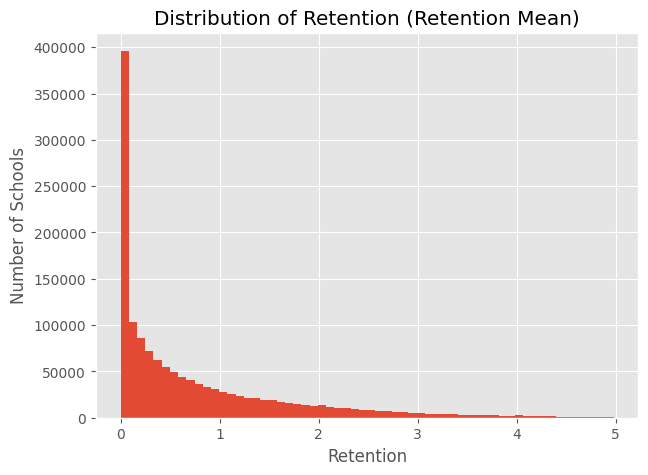

C:\Users\Ishaan Kaul\AppData\Local\Temp\ipykernel_24916\839407784.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend = df_ptr.groupby("ptr_bin")["retention_mean"].median()


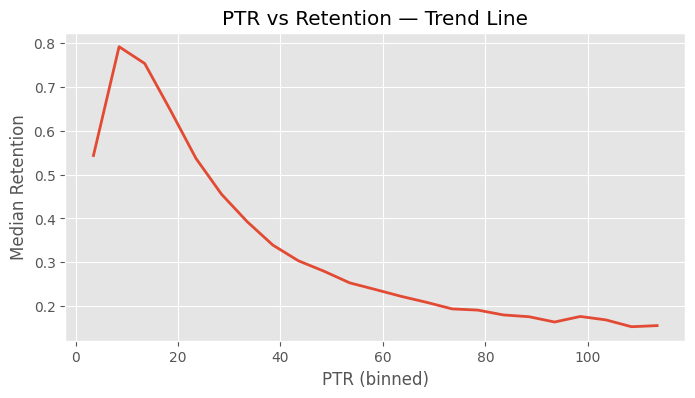

C:\Users\Ishaan Kaul\AppData\Local\Temp\ipykernel_24916\839407784.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


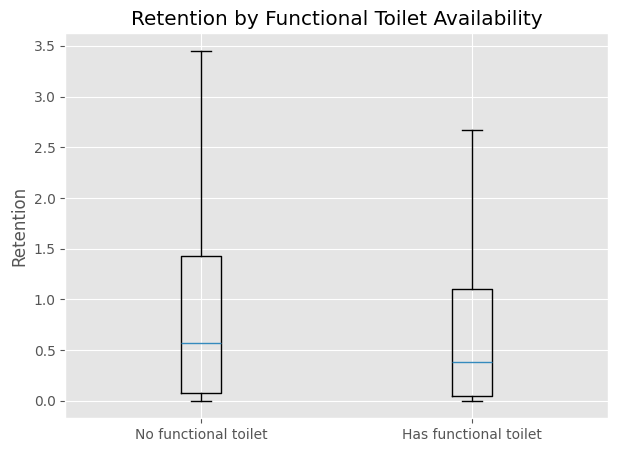

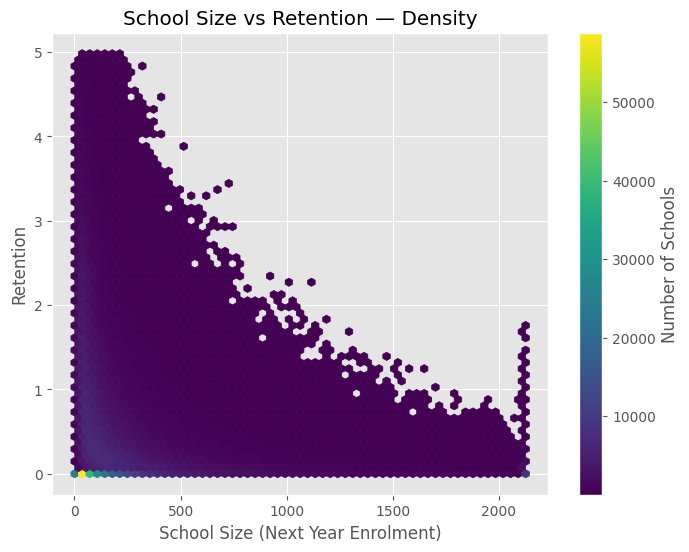

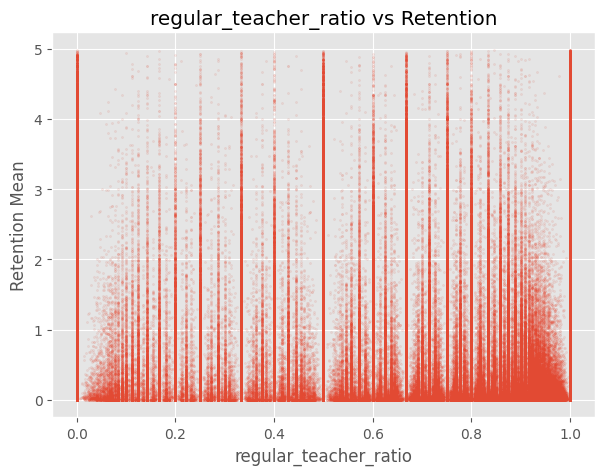

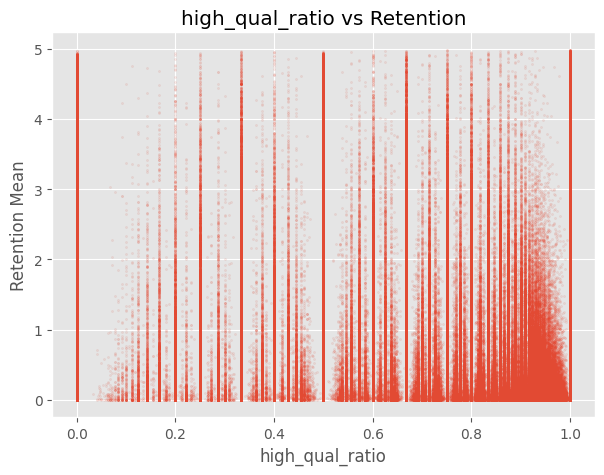

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Make plots bigger & cleaner
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (7,5)


# ===============================
# 1) Retention Distribution
# ===============================

plt.figure()
plt.hist(df_focus["retention_mean"].dropna(), bins=60)
plt.title("Distribution of Retention (Retention Mean)")
plt.xlabel("Retention")
plt.ylabel("Number of Schools")
plt.show()


# ===============================
# 2) PTR vs Retention (Hexbin)
# ===============================

df_ptr = df_focus[["ptr","retention_mean"]].dropna()

# Binned trend line
bins = np.arange(1, 121, 5)
df_ptr["ptr_bin"] = pd.cut(df_ptr["ptr"], bins=bins)
trend = df_ptr.groupby("ptr_bin")["retention_mean"].median()
mid_x = [(i.left + i.right)/2 for i in trend.index]

plt.figure(figsize=(8,4))
plt.plot(mid_x, trend.values, linewidth=2)
plt.xlabel("PTR (binned)")
plt.ylabel("Median Retention")
plt.title("PTR vs Retention — Trend Line")
plt.show()


# ===============================
# 3) Functional Toilets — Boxplot
# ===============================

bx = df_focus[["has_functional_toilet","retention_mean"]].dropna()

plt.figure()
plt.boxplot([
    bx.loc[bx["has_functional_toilet"]==0, "retention_mean"],
    bx.loc[bx["has_functional_toilet"]==1, "retention_mean"]
], labels=["No functional toilet", "Has functional toilet"], showfliers=False)
plt.title("Retention by Functional Toilet Availability")
plt.ylabel("Retention")
plt.show()

# ===============================
# 5) School Size vs Retention (Hexbin)
# ===============================

df_sz = df_focus[["total_enrol_next","retention_mean"]].dropna()
df_sz["total_enrol_next"] = df_sz["total_enrol_next"].clip(0, np.percentile(df_sz["total_enrol_next"], 99))

plt.figure(figsize=(8,6))
plt.hexbin(df_sz["total_enrol_next"], df_sz["retention_mean"], gridsize=60, mincnt=5)
plt.colorbar(label="Number of Schools")
plt.xlabel("School Size (Next Year Enrolment)")
plt.ylabel("Retention")
plt.title("School Size vs Retention — Density")
plt.show()


# ===============================
# 6) Teacher Quality Feature Relationships
# ===============================

for col in ["regular_teacher_ratio", "high_qual_ratio"]:
    plt.figure()
    plt.scatter(df_focus[col], df_focus["retention_mean"], s=2, alpha=0.1)
    plt.xlabel(col)
    plt.ylabel("Retention Mean")
    plt.title(f"{col} vs Retention")
    plt.show()

['retention_mean', 'retention_weighted', 'ptr', 'regular_teacher_ratio', 'contract_ratio', 'trained_ratio', 'high_qual_ratio', 'func_toilet_ratio', 'has_functional_toilet', 'handwash_near_toilet', 'total_enrol_next']


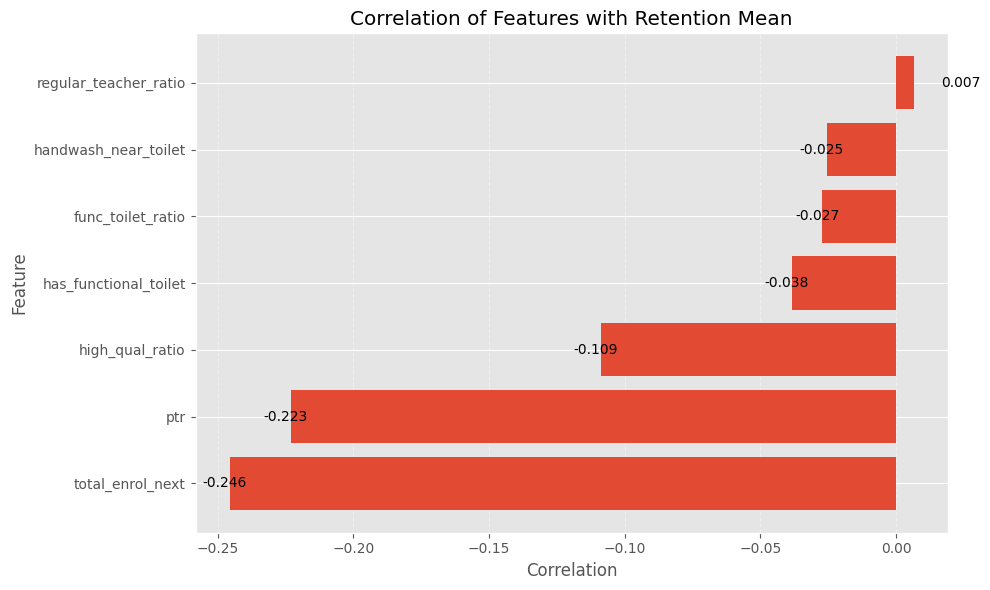

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Extract correlations with retention_mean
print(df_focus.columns.tolist())
df_focus.drop(columns=['retention_weighted', 'contract_ratio', 'trained_ratio'], errors='ignore', inplace=True)
corr_vals = df_focus.corr()["retention_mean"].drop("retention_mean")

# Sort by absolute correlation strength (optional, looks cleaner)
corr_vals = corr_vals.reindex(corr_vals.abs().sort_values(ascending=False).index)

plt.figure(figsize=(10,6))

# Plot
bars = plt.barh(corr_vals.index, corr_vals.values)

# Add numerical labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01 * np.sign(width), 
             bar.get_y() + bar.get_height()/2,
             f"{width:.3f}",
             va='center')

plt.title("Correlation of Features with Retention Mean")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [56]:
print("Retention Mean Summary:\n", model_df["retention_mean"].describe())
print("\nRetention Primary Summary:\n", model_df["retention_primary"].describe())
print("\nTransitions Summary:\n", model_df["transitions"].describe())

Retention Mean Summary:
 count    1.397781e+06
mean     7.514601e-01
std      9.292334e-01
min      0.000000e+00
25%      4.974533e-02
50%      3.859457e-01
75%      1.112987e+00
max      4.981481e+00
Name: retention_mean, dtype: float64

Retention Primary Summary:
 count    1.122594e+06
mean     1.014718e+00
std      1.111809e+00
min      0.000000e+00
25%      1.184211e-01
50%      6.011334e-01
75%      1.604167e+00
max      4.979167e+00
Name: retention_primary, dtype: float64

Transitions Summary:
 count    1.397781e+06
mean     5.238315e+00
std      2.345593e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      7.000000e+00
max      1.100000e+01
Name: transitions, dtype: float64


In [57]:
print("PTR Summary:\n", model_df["ptr"].describe())
print("PTR out of range:", ((model_df["ptr"] < 1) | (model_df["ptr"] > 120)).sum())

PTR Summary:
 count    1.397781e+06
mean     3.812042e+01
std      2.738428e+01
min      1.000000e+00
25%      1.866667e+01
50%      3.083333e+01
75%      4.928125e+01
max      1.200000e+02
Name: ptr, dtype: float64
PTR out of range: 0
